In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import os
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

# Functions 

In [2]:
# Function to provide basic information about a list of dataset
def data_basic_infor(table_dict):
    table_count = 0
    for keys, values in table_dict.items():
        number_row = len(values)
        start_date = min(values["date"])
        end_date = max(values["date"])
        table_count = table_count + 1
        column_name = values.columns
        frequency = values["date"][1] - values["date"][0]
        print("Table Number: " + str(table_count))
        print("Table Name: " + keys)
        print("Column Names: " + str(column_name[0]) + ", " + str(column_name[1]))
        print("Number of Row: "  + str(number_row))
        print("Frequency: " + str(frequency))
        print("Start Date: " + str(start_date))
        print("End Date: " + str(end_date))
        print("____________________________________________________________________________________________")

In [3]:
# Function for date formatting
def guess_date(string):
    for date_format in ["%Y-%m-%d", "%m/%d/%Y", "%d-%b-%y"]:
        try:
            return datetime.strptime(string, date_format).date()
        except ValueError:
            continue
    raise ValueError(string)

In [4]:
# Calculate the next 30 days realized volatility
def realized_vol(dataframe):
    prices = dataframe.loc[:, ["date", "adj close"]]
    prices["log_return"] = np.log(prices["adj close"]/prices["adj close"].shift(1))
    prices.fillna(0, inplace = True)
    prices = prices[::-1]
    prices["realized_vol"] = prices["log_return"].rolling(21).std()*(21**0.5)
    prices["realized_vol"] = prices["realized_vol"] * 300
    prices = prices[::-1]
    return prices

In [5]:
# Format monthly data to daily data
def monthly_to_daily(data):
    data["date"] = pd.to_datetime(data["date"], format = "%Y-%m")
    transformed_data = data.set_index("date").resample("D").ffill()
    date = transformed_data.index
    transformed_data = transformed_data.reset_index(drop = True)
    transformed_data["date"] = date
    return transformed_data

In [6]:
# Calculate the monthly change percentage (Derivate)
def get_monthly_change_rate(columns):
    monthly_change = [None]
    
    target_index = (columns.index + 1)
    target_index = target_index.drop([len(target_index)])
    
    for row in target_index:
        change = (columns[row]/columns[row - 1]) - 1
        monthly_change.append(change)
        
    return(monthly_change)
            

In [7]:
# Count the momentun of certain change (Consective change in the same direction)
def count_momentum(change_list):
    momentum_list = [0] * len(change_list)

    for index in change_list.index:
        count = index
        if pd.isnull(change_list[index]):  
            momentum_list[index] = None

        if change_list[index] > 0:
                while change_list[count] >= 0:
                    momentum_list[index] += 1
                    count -= 1

        if change_list[index] < 0:
                while change_list[count] <= 0:
                    momentum_list[index] -= 1
                    count -= 1
    return momentum_list

In [8]:
# Set the periods of recession
def periods_of_recession(recession_data, number_of_days):
    
    final_recession_data = [None] * len(recession_data)
    data = recession_data
    
    for i in range(len(data) - (number_of_days - 1)):
        recession_or_not = 0
        
        for j in range(i, i + number_of_days):
            recession_or_not += data[j]
        
        if recession_or_not == 0:
            final_recession_data[i] = 0
        else:
            final_recession_data[i] = 1
    
    return final_recession_data

# Read CSV Files in the Folder

In [9]:
# Adding working directory
directory = os.listdir("C:/Users/peter/Desktop/python-recession-model")

In [10]:
# Read all the data file
csv_file_list = []
csv_name = []
for file in directory:
    if file.endswith(".csv"):
        data_name = file.split(".")[0]
        data = pd.read_csv(file)
        csv_name.append(data_name)
        csv_file_list.append(data)

In [11]:
# Formating the file name
file_name = pd.DataFrame(csv_name).apply(lambda x: x.str.lower().str.replace('(', '').str.replace(')', '').str.replace('-', '').str.replace(',', ' ').str.replace(' ', '_').str.replace('__', '_'))

C:\Users\peter\AppData\Local\Temp\ipykernel_3480\897980676.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  file_name = pd.DataFrame(csv_name).apply(lambda x: x.str.lower().str.replace('(', '').str.replace(')', '').str.replace('-', '').str.replace(',', ' ').str.replace(' ', '_').str.replace('__', '_'))


In [12]:
# Creating the dictonary for file name to file
table_dict = {}

for i in range(len(file_name)):
        table_name = file_name.at[i, 0]
        data = pd.DataFrame(csv_file_list[i])
        table_dict[table_name] = data

In [13]:
# Format the date column name
for keys, values in table_dict.items():
    table_dict[keys] = values.rename(str.lower, axis = "columns")

# Format Date Object

In [14]:
for keys, values in table_dict.items():
    date_string = values["date"]
    date_format = ["%Y-%m-%d", "%m/%d/%Y", "%d-%b-%Y"]
    values["date"] = date_string.apply(lambda x: guess_date(x)).apply(lambda x: x.replace(year = x.year - 100) if x.year > 2030 else x )

# Basic Information of each dataset

In [15]:
# Overview of basic information about each dataset
data_basic_infor(table_dict)

Table Number: 1
Table Name: 10year_treasury_constant_maturity_minus_3month_treasury_constant_maturity
Column Names: date, t10y3m
Number of Row: 10958
Frequency: 1 day, 0:00:00
Start Date: 1982-01-04
End Date: 2024-01-03
____________________________________________________________________________________________
Table Number: 2
Table Name: capacity_utilization_total_index
Column Names: date, tcu
Number of Row: 681
Frequency: 31 days, 0:00:00
Start Date: 1967-01-01
End Date: 2023-09-01
____________________________________________________________________________________________
Table Number: 3
Table Name: consumer_price_index_for_all_urban_consumers_all_items_in_u
Column Names: date, cpiaucsl
Number of Row: 921
Frequency: 31 days, 0:00:00
Start Date: 1947-01-01
End Date: 2023-09-01
____________________________________________________________________________________________
Table Number: 4
Table Name: cpi
Column Names: date, cpiaucsl
Number of Row: 914
Frequency: 31 days, 0:00:00
Start Dat

# Updating Monthly Data to Daily Data

In [16]:
for keys, values in table_dict.items():
    table_dict[keys] = monthly_to_daily(table_dict[keys])

In [17]:
data_basic_infor(table_dict)

Table Number: 1
Table Name: 10year_treasury_constant_maturity_minus_3month_treasury_constant_maturity
Column Names: t10y3m, date
Number of Row: 15340
Frequency: 1 days 00:00:00
Start Date: 1982-01-04 00:00:00
End Date: 2024-01-03 00:00:00
____________________________________________________________________________________________
Table Number: 2
Table Name: capacity_utilization_total_index
Column Names: tcu, date
Number of Row: 20698
Frequency: 1 days 00:00:00
Start Date: 1967-01-01 00:00:00
End Date: 2023-09-01 00:00:00
____________________________________________________________________________________________
Table Number: 3
Table Name: consumer_price_index_for_all_urban_consumers_all_items_in_u
Column Names: cpiaucsl, date
Number of Row: 28003
Frequency: 1 days 00:00:00
Start Date: 1947-01-01 00:00:00
End Date: 2023-09-01 00:00:00
____________________________________________________________________________________________
Table Number: 4
Table Name: cpi
Column Names: cpiaucsl, date

# Backfilling Vix with S&P 500 Realized Volatility

In [18]:
# Historical Data for S&P500
sp500 = table_dict["sp500"]
# Realized volatility derived from S&P500 
realized_volatility = realized_vol(sp500).loc[:, ["date", "realized_vol"]].dropna()
# Historical Vix Data
vix = table_dict["vix"]

In [19]:
merged_vol = pd.merge(realized_volatility, vix, how = "left", on = "date")
merged_vol = merged_vol[(merged_vol["date"] >= "1982-1-4") & (merged_vol["date"] <= "2023-7-20")].reset_index()

In [20]:
merged_vol["final_vol"] = 0

for row_num in merged_vol.index:
    if  pd.isna(merged_vol.loc[row_num, "vixcls"]) == True :
        merged_vol.loc[row_num, "final_vol"] = merged_vol.loc[row_num, "realized_vol"]
    else:
        merged_vol.loc[row_num, "final_vol"] = merged_vol.loc[row_num, "vixcls"]

final_vol = merged_vol.loc[:,["date", "final_vol"]]
final_vol = final_vol.drop(final_vol[final_vol["final_vol"] == "."].index)

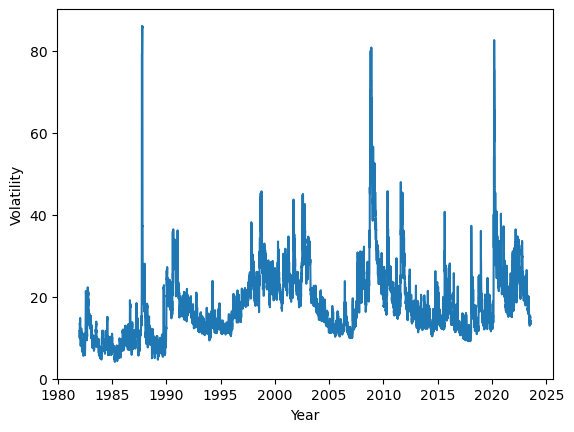

In [21]:
plt.plot(final_vol["date"],final_vol["final_vol"])
plt.ylabel("Volatility")
plt.xlabel("Year")
plt.show()

In [22]:
vix['vixcls'] = pd.to_numeric(vix['vixcls'], errors='coerce')

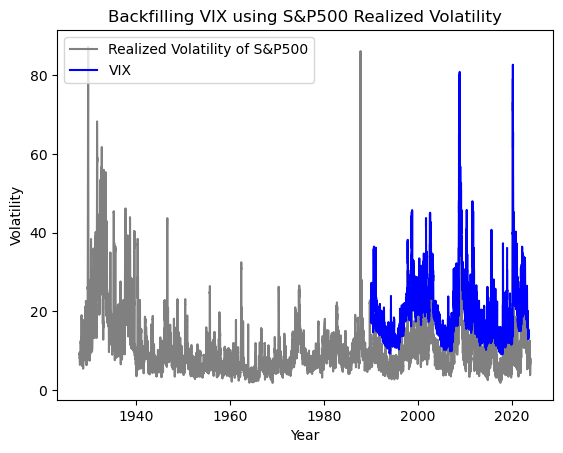

In [23]:
# Chart comparing VIX and S&P 500 Realized Volatility
plt.plot(realized_volatility["date"], realized_volatility["realized_vol"], color = "grey", label = "Realized Volatility of S&P500")
plt.plot(vix["date"], vix["vixcls"], color = "blue", label = "VIX")
plt.ylabel("Volatility")
plt.xlabel("Year")
plt.legend()
plt.title("Backfilling VIX using S&P500 Realized Volatility")
plt.show()

In [24]:
# Adding Final Volatility to Data Dictonary
table_dict["final_vol"] = final_vol

In [25]:
data_basic_infor(table_dict)

Table Number: 1
Table Name: 10year_treasury_constant_maturity_minus_3month_treasury_constant_maturity
Column Names: t10y3m, date
Number of Row: 15340
Frequency: 1 days 00:00:00
Start Date: 1982-01-04 00:00:00
End Date: 2024-01-03 00:00:00
____________________________________________________________________________________________
Table Number: 2
Table Name: capacity_utilization_total_index
Column Names: tcu, date
Number of Row: 20698
Frequency: 1 days 00:00:00
Start Date: 1967-01-01 00:00:00
End Date: 2023-09-01 00:00:00
____________________________________________________________________________________________
Table Number: 3
Table Name: consumer_price_index_for_all_urban_consumers_all_items_in_u
Column Names: cpiaucsl, date
Number of Row: 28003
Frequency: 1 days 00:00:00
Start Date: 1947-01-01 00:00:00
End Date: 2023-09-01 00:00:00
____________________________________________________________________________________________
Table Number: 4
Table Name: cpi
Column Names: cpiaucsl, date

# Adding Spread Rate of Change and Momentum

In [26]:
spread = table_dict["10year_treasury_constant_maturity_minus_3month_treasury_constant_maturity"]
spread = spread.drop(spread[spread["t10y3m"] == "."].index).reset_index()

In [27]:
spread["spread_derivative"] = get_monthly_change_rate(pd.to_numeric(spread["t10y3m"], errors='coerce'))
spread["spread_change_momentun"] = count_momentum(spread["spread_derivative"])
spread = spread.drop(["index"], axis = 1)

C:\Users\peter\AppData\Local\Temp\ipykernel_3480\775364193.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  change = (columns[row]/columns[row - 1]) - 1
C:\Users\peter\AppData\Local\Temp\ipykernel_3480\775364193.py:9: RuntimeWarning: invalid value encountered in scalar divide
  change = (columns[row]/columns[row - 1]) - 1


In [28]:
table_dict["spread"] = spread

# Adding Custom Recession Range

In [29]:
daily_recession_data = table_dict["nber_recession_daily"]
custom_range_recession_data = periods_of_recession(daily_recession_data["usrecd"], 90)
daily_recession_data["custom_recession_data"] = custom_range_recession_data
table_dict["custom_recession_data"] = daily_recession_data

In [30]:
table_dict["custom_recession_data"] = daily_recession_data

# Merge for final table

In [31]:
# Filter the list to delete based on the following requirements:
# 1. Has start date before 1975
# 2. Has end date after 2023
# 3. The update frequency is less than a month

list_to_delete = []
delta = timedelta(days = 32)
for keys, values in table_dict.items():
    frequency = values["date"][1] - values["date"][0]
    if min(values["date"]).year > 1982:
        list_to_delete.append(keys)
    elif frequency > delta:
        list_to_delete.append(keys)
    elif max(values["date"]).year < 2023:
        list_to_delete.append(keys)
        
        
print("The delete list has " + str(len(list_to_delete)) + " and has following items: ")
print("")

for table_name in list_to_delete:
    print(table_name)
    del table_dict[table_name]


The delete list has 7 and has following items: 

crude_oil_prices_west_texas_intermediate_wti_cushing_oklahoma
dji
economic_policy_uncertainty_index_for_united_states
inflation_consumer_prices_for_the_united_states
leading_index_for_the_united_states
updated_final_data_360
vix


In [32]:
table_dict_copy = table_dict.copy()

final_data = table_dict_copy["final_vol"]
del table_dict_copy["final_vol"]
del table_dict_copy["10year_treasury_constant_maturity_minus_3month_treasury_constant_maturity"]
del table_dict_copy["nber_recession_daily"]

for keys, values in table_dict_copy.items():
    print(keys)
    final_data = pd.merge(final_data, values, how = "left", on = "date")
    print(final_data)

capacity_utilization_total_index
            date  final_vol      tcu
0     1982-01-04  11.659821  75.0122
1     1982-01-05  11.619987  75.0122
2     1982-01-06   9.916682  75.0122
3     1982-01-07   9.965454  75.0122
4     1982-01-08  13.121723  75.0122
...          ...        ...      ...
14753 2023-07-16      13.34  79.6066
14754 2023-07-17      13.48  79.6066
14755 2023-07-18       13.3  79.6066
14756 2023-07-19      13.76  79.6066
14757 2023-07-20      13.99  79.6066

[14758 rows x 3 columns]
consumer_price_index_for_all_urban_consumers_all_items_in_u
            date  final_vol      tcu  cpiaucsl
0     1982-01-04  11.659821  75.0122    94.400
1     1982-01-05  11.619987  75.0122    94.400
2     1982-01-06   9.916682  75.0122    94.400
3     1982-01-07   9.965454  75.0122    94.400
4     1982-01-08  13.121723  75.0122    94.400
...          ...        ...      ...       ...
14753 2023-07-16      13.34  79.6066   304.348
14754 2023-07-17      13.48  79.6066   304.348
14755 2023-07-

            date  final_vol      tcu  cpiaucsl_x  cpiaucsl_y  fedfunds    dff  \
0     1982-01-04  11.659821  75.0122      94.400        94.4     13.22  13.31   
1     1982-01-05  11.619987  75.0122      94.400        94.4     13.22  12.90   
2     1982-01-06   9.916682  75.0122      94.400        94.4     13.22  12.12   
3     1982-01-07   9.965454  75.0122      94.400        94.4     13.22  12.37   
4     1982-01-08  13.121723  75.0122      94.400        94.4     13.22  12.12   
...          ...        ...      ...         ...         ...       ...    ...   
14753 2023-07-16      13.34  79.6066     304.348         NaN       NaN   5.08   
14754 2023-07-17      13.48  79.6066     304.348         NaN       NaN   5.08   
14755 2023-07-18       13.3  79.6066     304.348         NaN       NaN   5.08   
14756 2023-07-19      13.76  79.6066     304.348         NaN       NaN   5.08   
14757 2023-07-20      13.99  79.6066     304.348         NaN       NaN   5.08   

         indpro    icsa  ci

In [33]:
final_data

,date,final_vol,tcu,cpiaucsl_x,cpiaucsl_y,fedfunds,dff,indpro,icsa,civpart,...,volume,unrate,umcsent,mich,m2v,t10y3m,spread_derivative,spread_change_momentun,usrecd,custom_recession_data
0,1982-01-04,11.659821,75.0122,94.400,94.4,13.22,13.31,48.7979,495000,63.7,...,36760000,8.6,71.0,5.1,1.842,2.32,NaN,NaN,1,1.0
1,1982-01-05,11.619987,75.0122,94.400,94.4,13.22,12.90,48.7979,495000,63.7,...,47510000,8.6,71.0,5.1,1.842,2.24,-0.034483,-1.0,1,1.0
2,1982-01-06,9.916682,75.0122,94.400,94.4,13.22,12.12,48.7979,495000,63.7,...,51510000,8.6,71.0,5.1,1.842,2.43,0.084821,1.0,1,1.0
3,1982-01-07,9.965454,75.0122,94.400,94.4,13.22,12.37,48.7979,495000,63.7,...,43410000,8.6,71.0,5.1,1.842,2.46,0.012346,2.0,1,1.0
4,1982-01-08,13.121723,75.0122,94.400,94.4,13.22,12.12,48.7979,495000,63.7,...,42050000,8.6,71.0,5.1,1.842,2.50,0.016260,3.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14753,2023-07-16,13.34,79.6066,304.348,NaN,NaN,5.08,103.2895,228000,NaN,...,3647450000,3.5,71.6,3.4,NaN,-1.66,0.000000,0.0,0,0.0
14754,2023-07-17,13.48,79.6066,304.348,NaN,NaN,5.08,103.2895,228000,NaN,...,3538240000,3.5,71.6,3.4,NaN,-1.68,0.012048,3.0,0,0.0
14755,2023-07-18,13.3,79.6066,304.348,NaN,NaN,5.08,103.2895,228000,NaN,...,4090010000,3.5,71.6,3.4,NaN,-1.69,0.005952,4.0,0,0.0
14756,2023-07-19,13.76,79.6066,304.348,NaN,NaN,5.08,103.2895,228000,NaN,...,4115670000,3.5,71.6,3.4,NaN,-1.74,0.029586,5.0,0,0.0


In [34]:
updated_final_data = final_data.drop(["cpiaucsl_y", "open", "high", "low", "close"], axis = 1).dropna().reset_index().drop(["index"], axis = 1)

In [35]:
updated_final_data

,date,final_vol,tcu,cpiaucsl_x,fedfunds,dff,indpro,icsa,civpart,m1sl,...,volume,unrate,umcsent,mich,m2v,t10y3m,spread_derivative,spread_change_momentun,usrecd,custom_recession_data
0,1982-01-05,11.619987,75.0122,94.400,13.22,12.90,48.7979,495000,63.7,442.7,...,47510000,8.6,71.0,5.1,1.842,2.24,-0.034483,-1.0,1,1.0
1,1982-01-06,9.916682,75.0122,94.400,13.22,12.12,48.7979,495000,63.7,442.7,...,51510000,8.6,71.0,5.1,1.842,2.43,0.084821,1.0,1,1.0
2,1982-01-07,9.965454,75.0122,94.400,13.22,12.37,48.7979,495000,63.7,442.7,...,43410000,8.6,71.0,5.1,1.842,2.46,0.012346,2.0,1,1.0
3,1982-01-08,13.121723,75.0122,94.400,13.22,12.12,48.7979,495000,63.7,442.7,...,42050000,8.6,71.0,5.1,1.842,2.50,0.016260,3.0,1,1.0
4,1982-01-09,13.559336,75.0122,94.400,13.22,12.12,48.7979,545000,63.7,442.7,...,42050000,8.6,71.0,5.1,1.842,2.50,0.000000,0.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14392,2023-02-25,21.67,79.5454,301.648,4.57,4.58,102.5671,221000,62.5,19327.8,...,3877700000,3.6,67,4.1,1.273,-0.91,0.000000,0.0,0,0.0
14393,2023-02-26,21.67,79.5454,301.648,4.57,4.58,102.5671,221000,62.5,19327.8,...,3877700000,3.6,67,4.1,1.273,-0.91,0.000000,0.0,0,0.0
14394,2023-02-27,20.95,79.5454,301.648,4.57,4.57,102.5671,221000,62.5,19327.8,...,3836950000,3.6,67,4.1,1.273,-0.97,0.065934,3.0,0,0.0
14395,2023-02-28,20.7,79.5454,301.648,4.57,4.57,102.5671,221000,62.5,19327.8,...,5043400000,3.6,67,4.1,1.273,-0.96,-0.010309,-1.0,0,0.0


In [36]:
updated_final_data["t10y3m"] = pd.to_numeric(updated_final_data['t10y3m'], errors='coerce')
updated_final_data["umcsent"] = pd.to_numeric(updated_final_data['umcsent'], errors='coerce')
updated_final_data["final_vol"] = pd.to_numeric(updated_final_data['final_vol'], errors='coerce')

In [37]:
updated_final_data["cycle_indicator"] = updated_final_data["t10y3m"]/updated_final_data["final_vol"]

In [38]:
updated_final_data.head(60)

,date,final_vol,tcu,cpiaucsl_x,fedfunds,dff,indpro,icsa,civpart,m1sl,...,unrate,umcsent,mich,m2v,t10y3m,spread_derivative,spread_change_momentun,usrecd,custom_recession_data,cycle_indicator
0,1982-01-05,11.619987,75.0122,94.4,13.22,12.90,48.7979,495000,63.7,442.7,...,8.6,71.0,5.1,1.842,2.24,-0.034483,-1.0,1,1.0,0.192771
1,1982-01-06,9.916682,75.0122,94.4,13.22,12.12,48.7979,495000,63.7,442.7,...,8.6,71.0,5.1,1.842,2.43,0.084821,1.0,1,1.0,0.245042
2,1982-01-07,9.965454,75.0122,94.4,13.22,12.37,48.7979,495000,63.7,442.7,...,8.6,71.0,5.1,1.842,2.46,0.012346,2.0,1,1.0,0.246853
3,1982-01-08,13.121723,75.0122,94.4,13.22,12.12,48.7979,495000,63.7,442.7,...,8.6,71.0,5.1,1.842,2.50,0.016260,3.0,1,1.0,0.190524
4,1982-01-09,13.559336,75.0122,94.4,13.22,12.12,48.7979,545000,63.7,442.7,...,8.6,71.0,5.1,1.842,2.50,0.000000,0.0,1,1.0,0.184375
5,1982-01-10,13.559336,75.0122,94.4,13.22,12.12,48.7979,545000,63.7,442.7,...,8.6,71.0,5.1,1.842,2.50,0.000000,0.0,1,1.0,0.184375
6,1982-01-11,13.559336,75.0122,94.4,13.22,12.64,48.7979,545000,63.7,442.7,...,8.6,71.0,5.1,1.842,2.32,-0.072000,-3.0,1,1.0,0.171100
7,1982-01-12,13.325256,75.0122,94.4,13.22,12.88,48.7979,545000,63.7,442.7,...,8.6,71.0,5.1,1.842,2.10,-0.094828,-4.0,1,1.0,0.157595
8,1982-01-13,13.254715,75.0122,94.4,13.22,12.66,48.7979,545000,63.7,442.7,...,8.6,71.0,5.1,1.842,2.13,0.014286,1.0,1,1.0,0.160698
9,1982-01-14,13.327275,75.0122,94.4,13.22,12.75,48.7979,545000,63.7,442.7,...,8.6,71.0,5.1,1.842,1.53,-0.281690,-1.0,1,1.0,0.114802


In [39]:
monthly_data = updated_final_data[updated_final_data['date'] == updated_final_data['date'] + pd.offsets.MonthEnd(0)]

In [40]:
monthly_data.isna().sum()

date                      0
final_vol                 0
tcu                       0
cpiaucsl_x                0
fedfunds                  0
dff                       0
indpro                    0
icsa                      0
civpart                   0
m1sl                      0
m2sl                      0
mabmm301usm189s           0
bogmbase                  0
adj close                 0
volume                    0
unrate                    0
umcsent                   0
mich                      0
m2v                       0
t10y3m                    0
spread_derivative         0
spread_change_momentun    0
usrecd                    0
custom_recession_data     0
cycle_indicator           0
dtype: int64

In [41]:
# Exporting Final Dataset
monthly_data.to_csv("updated_final_data_90.csv")

In [42]:
import pandas as pd

# Create a sample DataFrame with a 'date' column
data = {'date': pd.date_range(start='2022-06-25', end='2022-06-30', freq='D'),
        'value': [10, 15, 20, 25, 30, 35]}
df = pd.DataFrame(data)

# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter the DataFrame to include only month-end dates
df_month_end = df[df['date'] == df['date'] + pd.offsets.MonthEnd(0)]

print("Original DataFrame:")
print(df)
print("\nDataFrame with Month-End Dates:")
print(df_month_end)


Original DataFrame:
        date  value
0 2022-06-25     10
1 2022-06-26     15
2 2022-06-27     20
3 2022-06-28     25
4 2022-06-29     30
5 2022-06-30     35

DataFrame with Month-End Dates:
        date  value
5 2022-06-30     35
